In [1]:
# import SharedArray as sa
# ROBOT_TYPE_NAME = 'panda'
# sa.delete("shm://{}.prepared".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.grasp_img".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.arm_img".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.rh_vals".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.result".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.query_in".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.response_out".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.query_quit".format(ROBOT_TYPE_NAME))

## Define printing function

In [1]:
from plot_scripts import *

## Print results

RES_ROOT: stowing-deep-result-btf-ik08-to2.0
DAT_DIR: 20210917-113211
CNAME_LIST: ['None', 'Tool', 'ToolReach', 'Full']
obj_1
obj_1_obs3
obj_1_obs5
obj_3
obj_3_pole
obj_3_hard
obj_1c_obs0
None files: 50
Tool files: 50
ToolReach files: 50
Full files: 50
================================================== obj_1c_obs0 ================================================== valid=50
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :     2.27      5.0     3.74     3.74(100.0)     0.52(10.32)     8.68     8.68(100.0)     5.28(44.18)      0.0       50
Tool      :     2.51     5.08     4.18     4.18(100.0)     0.76(10.98)    12.74     7.04(68.18)     3.12(26.22)      0.0       50
ToolReach :     2.29      5.0     3.98     3.98(100.0)      0.7(11.53)     11.4     5.24(61.76)     1.34(16.22)      0.0       50
Full      :     1.85      5.0     3.78     3.78(100.0)     0.48( 9.54)    19.92      5.7(42.56)     1.44

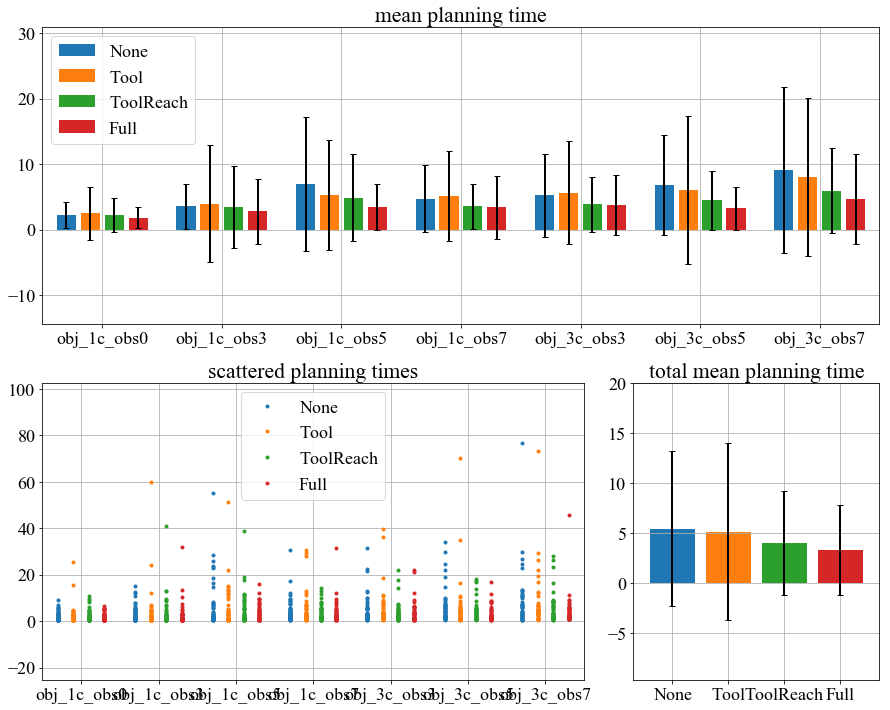

In [2]:
plt.rcParams['font.size'] = 18
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['lines.linewidth'] = 2
CNAME_LIST = ['None', 'Tool', 'ToolReach', 'Full']
resdat_all, res_dict_all = print_results(RES_ROOT="stowing-deep-result-btf-ik08-to2.0", 
                                         RTYPE="panda", 
                                         DAT_DIR='20210917-113211',
                                         CNAME_LIST=CNAME_LIST,
#                                          exp_list=['obj_1',
#                                                    'obj_1_obs3',
#                                                    'obj_1_obs5',
#                                                    'obj_3',
#                                                    'obj_3_pole',
#                                                    'obj_3_hard',
#                                                    'obj_1c_obs0',
#                                                    'obj_1c_obs3',
#                                                    'obj_1c_obs5',
#                                                    'obj_1c_obs7',
#                                                    'obj_3c_obs3',
#                                                    'obj_3c_obs5']
                                        )
plot_times(resdat_all, CHECKERS=CNAME_LIST)

Text(0.5,1,'success ratios tot')

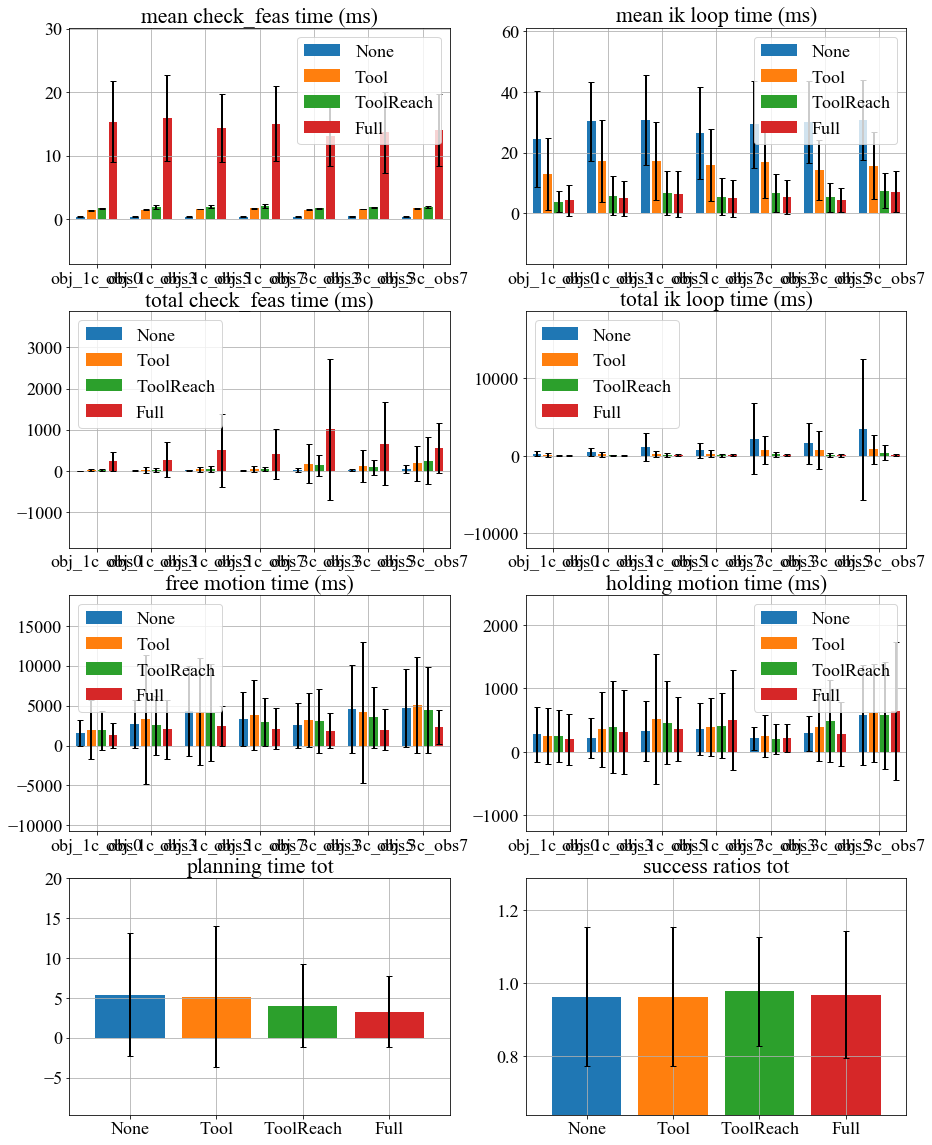

In [3]:
scatter = False

plt.figure(figsize=(15,20))
plt.subplot(4,2,1)
plot_valid(resdat_all, keys=["time_log", "check_feas"], fn=np.mean, scatter=scatter, CHECKERS=CNAME_LIST)
plt.title("mean check_feas time (ms)")
plt.subplot(4,2,2)
plot_valid(resdat_all, keys=["time_log", "ik_loop"], fn=np.mean, scatter=scatter, CHECKERS=CNAME_LIST)
plt.title("mean ik loop time (ms)")

plt.subplot(4,2,3)
plot_valid(resdat_all, keys=["time_log", "check_feas"], fn=np.sum, scatter=scatter, CHECKERS=CNAME_LIST)
plt.title("total check_feas time (ms)")
plt.subplot(4,2,4)
plot_valid(resdat_all, keys=["time_log", "ik_loop"], fn=np.sum, scatter=scatter, CHECKERS=CNAME_LIST)
plt.title("total ik loop time (ms)")

plt.subplot(4,2,5)
fm_dict = plot_valid(resdat_all, keys=['time_log', "free_motion_gen"], fn=np.sum, scatter=scatter, CHECKERS=CNAME_LIST)
plt.title("free motion time (ms)")
plt.subplot(4,2,6)
plot_valid(resdat_all, keys=['time_log', "holding_motion_gen"], fn=np.sum, scatter=scatter, CHECKERS=CNAME_LIST)
plt.title("holding motion time (ms)")

plt.subplot(4,2,7)
time_dict = plot_valid(resdat_all, keys=["plan_time"], average_all=True, CHECKERS=CNAME_LIST)
plt.title("planning time tot")
plt.subplot(4,2,8)
succ_dict = extract_values(resdat_all, ["success"])
_ = grouped_bar(succ_dict, average_all=True, options=CNAME_LIST)
plt.title("success ratios tot")

In [316]:
XLABEL_DICT = {'None':'None', 'Tool':'Step 1', 'ToolReach': 'Step 2', 'Full': 'Step 3'}
XLABEL_LIST = ['None', 'Step 1', 'Step 2', 'Step 3']

In [317]:
for resdict in resdat_all.values():
    for k, v in resdict.items():
        resdict[XLABEL_DICT[k]] = v

KeyError: 'Step 2'

(-5, 15)

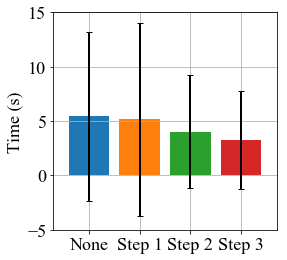

In [318]:
plt.rcParams['font.size'] = 18
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['lines.linewidth'] = 2

fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1,1,1)

time_dict = plot_valid(resdat_all, keys=["plan_time"], average_all=True, CHECKERS=XLABEL_LIST)
plt.ylabel("Time (s)")
plt.ylim(-5,15)
# plt.title("planning time tot")

(80, 100)

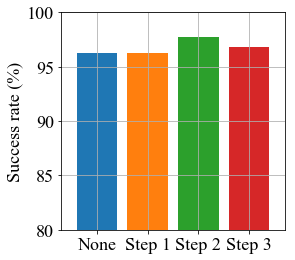

In [319]:
plt.rcParams['font.size'] = 18
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['lines.linewidth'] = 2

fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1,1,1)

succ_dict = extract_values(resdat_all, ["success"])
for k, v in succ_dict.items():
    for kk, vv in v.items():
        v[kk] = np.multiply(np.array(vv, dtype=np.float), 100)
_ = grouped_bar(succ_dict, average_all=True, options=XLABEL_LIST, show_bar=False)
plt.ylabel("Success rate (%)")
plt.ylim(80,100)
# plt.title("success ratios tot")

Text(0.5,1,'Success rate(%), timeout=15 s')

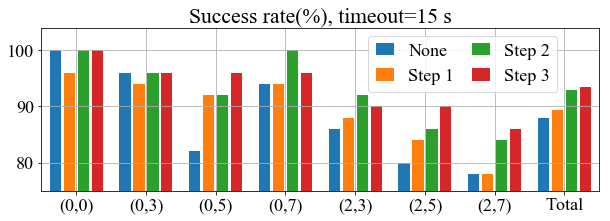

In [320]:
TIMEOUT = 15
N_SAMPLE = 50
XLABEL_LIST = ['None', 'Step 1', 'Step 2', 'Step 3']

time_dict_all = extract_values(resdat_all, ["plan_time"])
        
succ_dict_to = {}
for k, v in sorted(time_dict_all.items()):
    succ_dict_to[k] = {}
    for cname in CNAME_LIST:
        kk = cname
        vv = np.array(v[kk])
        succ_rate = np.sum(vv<TIMEOUT).astype(float)/N_SAMPLE*100
        succ_dict_to[k][kk] = succ_rate
        
for valdict in succ_dict_to.values():
    for k, v in valdict.items():
        valdict[XLABEL_DICT[k]] = v
        
succ_dict_to_rev = {}
val_list_dict = defaultdict(list)
key_remove = [] # ["(0,7)"]
for ckey, valdic in sorted(succ_dict_to.items()):
    ckey_new = "({},{})".format(int(ckey[4:5])-1, int(ckey[-1:]))
    if ckey_new not in key_remove:
        succ_dict_to_rev[ckey_new] = valdic
        for fkey, value in valdic.items():
            val_list_dict[fkey].append(value)
        
mean_dict = {}
for fkey, val_list in val_list_dict.items():
    mean_dict[fkey] = np.mean(val_list)
    
succ_dict_to_rev["Total"] = mean_dict
        
plt.figure(figsize=(10,3))
_ = grouped_bar(succ_dict_to_rev, options=XLABEL_LIST)
plt.legend(XLABEL_LIST, ncol=len(XLABEL_LIST)/2, handlelength=1, labelspacing=0.5, columnspacing=1, bbox_to_anchor=(0.57,0.55))
plt.ylim(75, 104)
plt.title("Success rate(%), timeout={} s".format(TIMEOUT))

In [330]:
succ_dict_to_rev["Total"]["Step 3"] - succ_dict_to_rev["Total"]["None"]

5.428571428571431

Text(0.5,1,'Mean planning time (s)')

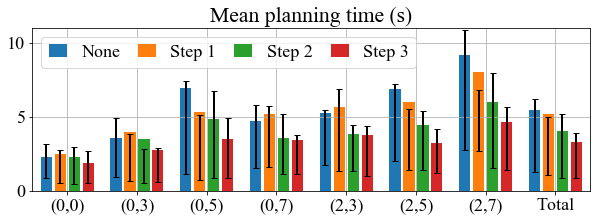

In [327]:
N_SAMPLE = 50
XLABEL_LIST = ['None', 'Step 1', 'Step 2', 'Step 3']

time_dict_valids = extract_valid(resdat_all, ["plan_time"])

time_dict = {}
for k, v in sorted(time_dict_valids.items()):
    time_dict[k] = {}
    for cname in CNAME_LIST:
        kk = cname
        vv = np.array(v[kk])
        time_dict[k][kk] = vv
        
for valdict in time_dict.values():
    for k, v in valdict.items():
        valdict[XLABEL_DICT[k]] = v
        if k not in XLABEL_LIST and k in valdict:
            del valdict[k]
            
time_dict_rev = {}
val_list_dict = defaultdict(list)
key_remove = [] # ["(0,7)"]
for ckey, valdic in sorted(time_dict.items()):
    ckey_new = "({},{})".format(int(ckey[4:5])-1, int(ckey[-1:]))
    if ckey_new not in key_remove:
        time_dict_rev[ckey_new] = valdic
        for fkey, value in valdic.items():
            val_list_dict[fkey] = np.array(list(val_list_dict[fkey]) + list(value))
        
time_dict_rev["Total"] = val_list_dict

plt.figure(figsize=(10,3))
keys = grouped_bar(time_dict_rev, options=XLABEL_LIST, show_bar=0.5, fn=np.mean)#, scatter=True)
plt.legend(XLABEL_LIST, ncol=len(XLABEL_LIST), handlelength=1, labelspacing=0, columnspacing=1)
# plt.legend(XLABEL_LIST, bbox_to_anchor=(0.25,0.5))
plt.ylim(0,11)
plt.title("Mean planning time (s)")

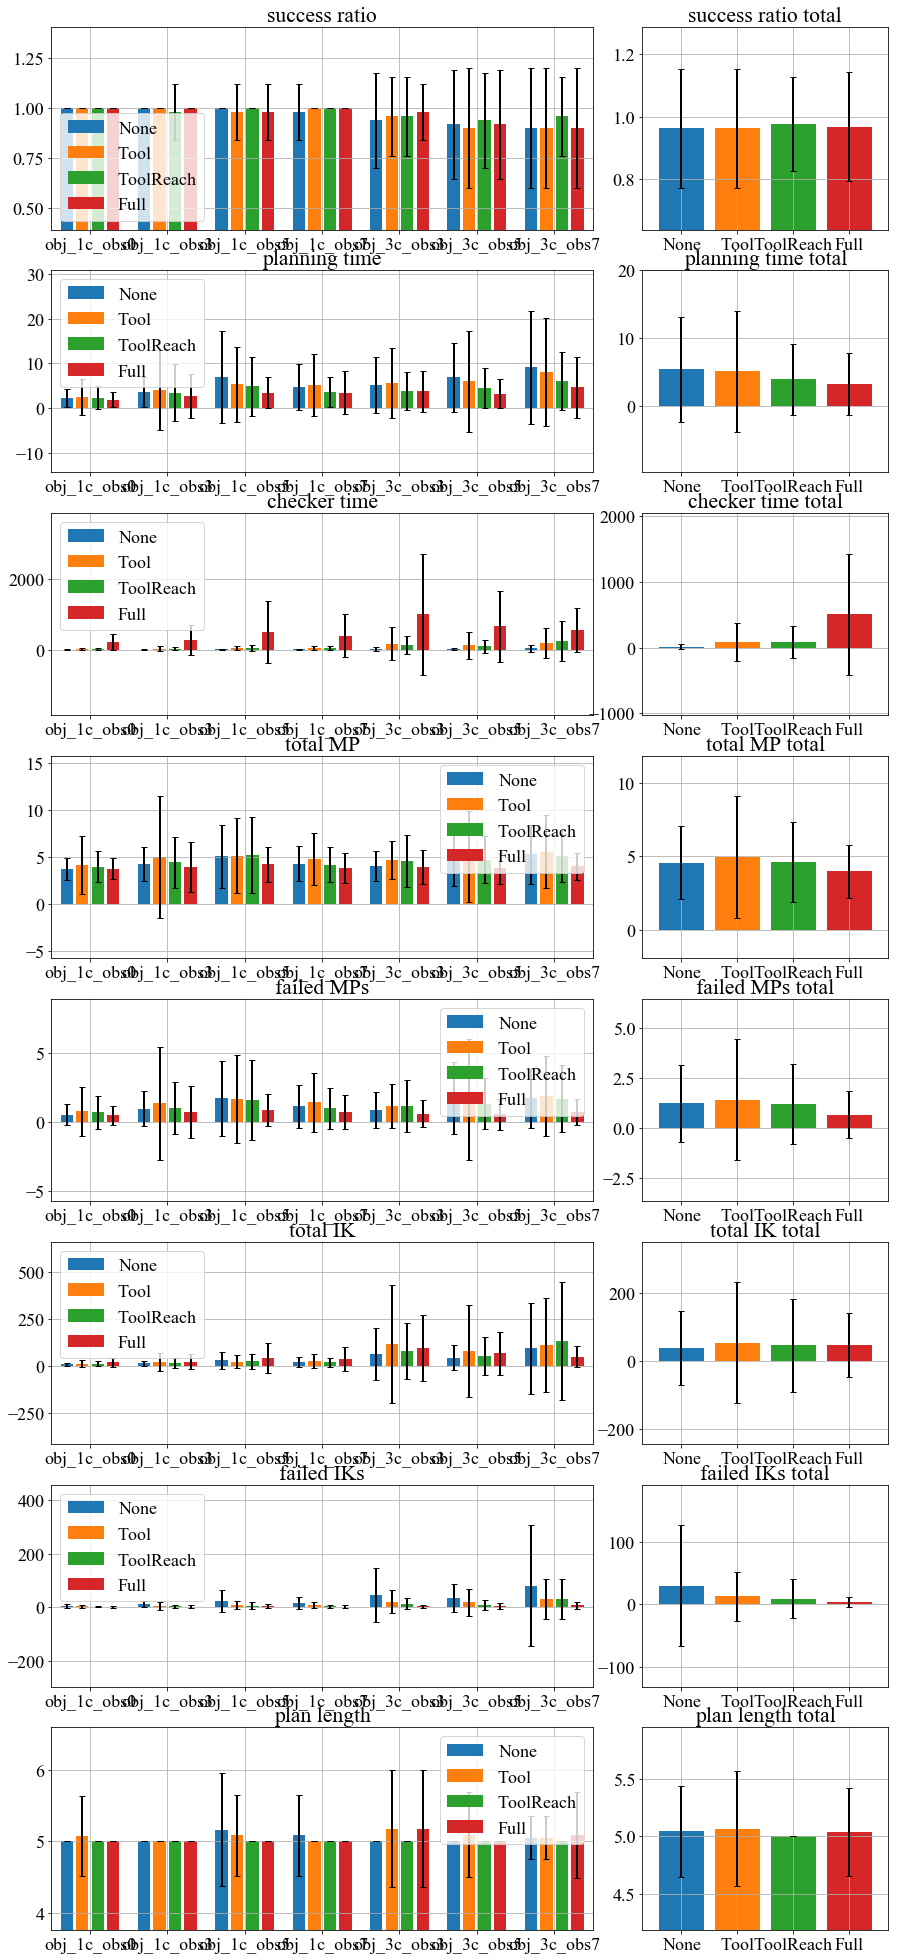

In [10]:
plt.figure(figsize=(15,35))

ROWS = 8
COLS = 3   
    
succ_dict = extract_values(resdat_all, ["success"])
subplot_trisect_line(ROWS, COLS, 1, succ_dict, "success ratio", options=CNAME_LIST)
subplot_trisect_line(ROWS, COLS, 2, extract_valid(resdat_all, ["plan_time"]), "planning time", options=CNAME_LIST)
subplot_trisect_line(ROWS, COLS, 3, 
                     extract_valid(resdat_all, ["time_log", "check_feas"], fn=np.sum), "checker time", options=CNAME_LIST)
subplot_trisect_line(ROWS, COLS, 4, extract_valid(resdat_all, ["MP_tot"]), "total MP", options=CNAME_LIST)
subplot_trisect_line(ROWS, COLS, 5, extract_valid(resdat_all, ["failed_MPs"]), "failed MPs", options=CNAME_LIST)
subplot_trisect_line(ROWS, COLS, 6, extract_valid(resdat_all, ["IK_tot"]), "total IK", options=CNAME_LIST)
subplot_trisect_line(ROWS, COLS, 7, extract_valid(resdat_all, ["failed_IKs"]), "failed IKs", options=CNAME_LIST)
subplot_trisect_line(ROWS, COLS, 8, extract_valid(resdat_all, ["length"]), "plan length", options=CNAME_LIST)

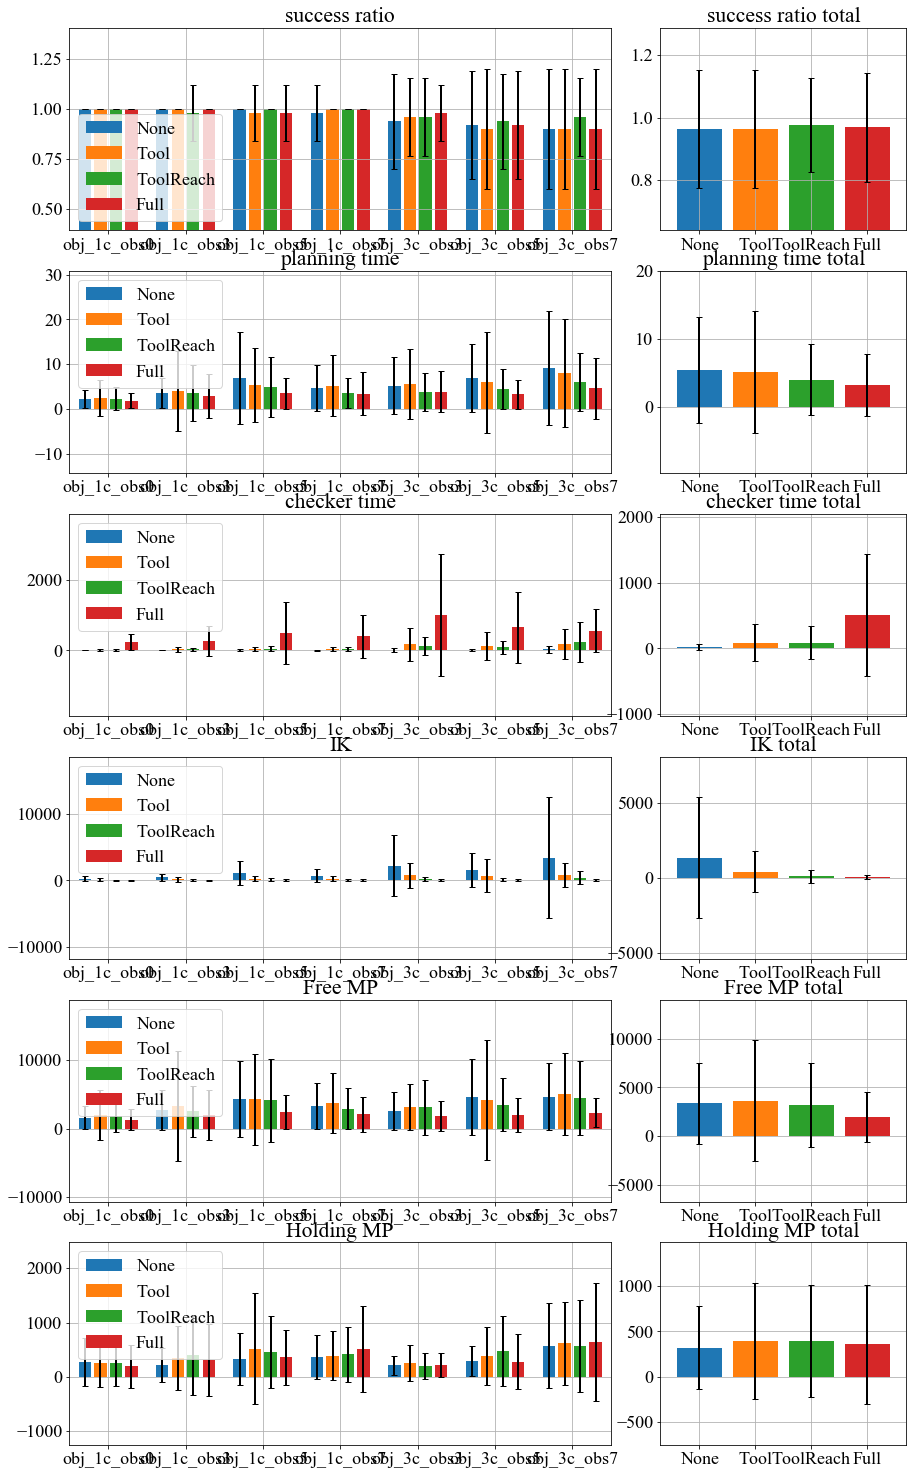

In [11]:
plt.figure(figsize=(15,35))

ROWS = 8
COLS = 3   
    
succ_dict = extract_values(resdat_all, ["success"])
subplot_trisect_line(ROWS, COLS, 1, succ_dict, "success ratio", options=CNAME_LIST)
subplot_trisect_line(ROWS, COLS, 2, extract_valid(resdat_all, ["plan_time"]), "planning time", options=CNAME_LIST)
subplot_trisect_line(ROWS, COLS, 3, 
                     extract_valid(resdat_all, ["time_log", "check_feas"], fn=np.sum), "checker time", options=CNAME_LIST)
subplot_trisect_line(ROWS, COLS, 4, 
                     extract_valid(resdat_all, ["time_log", "ik_loop"], fn=np.sum), "IK", options=CNAME_LIST)
subplot_trisect_line(ROWS, COLS, 5, 
                     extract_valid(resdat_all, ["time_log", "free_motion_gen"], fn=np.sum), "Free MP", options=CNAME_LIST)
subplot_trisect_line(ROWS, COLS, 6, 
                     extract_valid(resdat_all, ["time_log", "holding_motion_gen"], fn=np.sum), "Holding MP", options=CNAME_LIST)

In [267]:
def combine_by_obsnum(value_dict, keys=[0, 3, 5, 7]):
    value_dict_new = {}
    for k in keys:
        k1 = 'obj_1c_obs{}'.format(k)
        k2 = 'obj_3c_obs{}'.format(k)
        value_dict_new[k] = {}
        for cname in value_dict[k1].keys():
            if k2 in value_dict:
                value_dict_new[k][cname] = np.concatenate([value_dict[k1][cname], value_dict[k2][cname]])
            else:
                value_dict_new[k][cname] = np.copy(value_dict[k1][cname])
    return value_dict_new

In [268]:
CNAME_LIST = ['None', 'Tool', 'ToolReach', 'Full']
times_full = combine_by_obsnum(extract_valid(resdat_all, ["plan_time"], CHECKERS=CNAME_LIST))
times_check = combine_by_obsnum(extract_valid(resdat_all, ["time_log", "check_feas"], CHECKERS=CNAME_LIST, fn=np.sum))
times_ik = combine_by_obsnum(extract_valid(resdat_all, ["time_log", "ik_loop"], CHECKERS=CNAME_LIST, fn=np.sum))
times_fm = combine_by_obsnum(extract_valid(resdat_all, ["time_log", "free_motion_gen"], CHECKERS=CNAME_LIST, fn=np.sum))
times_hm = combine_by_obsnum(extract_valid(resdat_all, ["time_log", "holding_motion_gen"], CHECKERS=CNAME_LIST, fn=np.sum))
times_mp = {}
for case in times_fm.keys():
    times_case = {}
    for cname in CNAME_LIST:
        times_case[cname] = np.add(times_fm[case][cname], times_hm[case][cname])
    times_mp[case] = times_case

In [269]:
XLABEL_DICT = {'None':'None', 'Tool':'Step1', 'ToolReach': 'Step2', 'Full': 'Step3'}
XLABEL_LIST = ['None', 'Step1', 'Step2', 'Step3']
for times_dict in [times_full, times_check, times_ik, times_mp]:
    times_dict_new = {}
    for case in times_dict.keys():
        times_case = {}
        for cname in CNAME_LIST:
            times_case[XLABEL_DICT[cname]] = times_dict[case][cname]
        times_dict_new[case] = times_case
    times_dict.clear()
    times_dict.update(times_dict_new)

In [271]:
for case in times_check.keys():
    for cname in times_check[case].keys():
        times_check[case][cname] /= 1000
        
for case in times_ik.keys():
    for cname in times_ik[case].keys():
        times_ik[case][cname] /= 1000
        
for case in times_mp.keys():
    for cname in times_mp[case].keys():
        times_mp[case][cname] /= 1000

Text(0.5,1,'MP (s)')

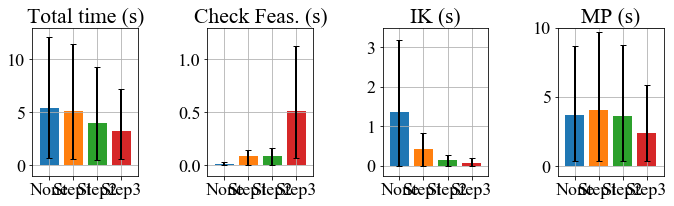

In [272]:
plt.rcParams['font.size'] = 18
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['lines.linewidth'] = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,3))
fig.tight_layout()
plt.subplot(1,4,1)
_ = grouped_bar(times_full, average_all=True, options=XLABEL_LIST, show_bar=0.8)
plt.ylim(-1,13)
plt.title("Total time (s)")
plt.subplot(1,4,2)
_ = grouped_bar(times_check, average_all=True, options=XLABEL_LIST, show_bar=0.8)
plt.ylim(-0.100,1.300)
plt.title("Check Feas. (s)")
plt.subplot(1,4,3)
_ = grouped_bar(times_ik, average_all=True, options=XLABEL_LIST, show_bar=0.8)
plt.ylim(-0.250,3.500)
plt.title("IK (s)")
plt.subplot(1,4,4)
_ = grouped_bar(times_mp, average_all=True, options=XLABEL_LIST, show_bar=0.8)
plt.ylim(-0.700,10.000)
plt.title("MP (s)")

In [273]:
def combine_by_case(val_dict):
    val_dict = swap_double_dict(val_dict)
    for k, vdict in val_dict.items():
        val_dict[k] = np.concatenate(map(lambda x: x[1], sorted(vdict.items())))
    return val_dict

In [274]:
times_full = combine_by_case(extract_valid(resdat_all, ["plan_time"], CHECKERS=CNAME_LIST))
times_check = combine_by_case(extract_valid(resdat_all, ["time_log", "check_feas"], CHECKERS=CNAME_LIST, fn=np.sum))
times_ik = combine_by_case(extract_valid(resdat_all, ["time_log", "ik_loop"], CHECKERS=CNAME_LIST, fn=np.sum))
times_fm = combine_by_case(extract_valid(resdat_all, ["time_log", "free_motion_gen"], CHECKERS=CNAME_LIST, fn=np.sum))
times_hm = combine_by_case(extract_valid(resdat_all, ["time_log", "holding_motion_gen"], CHECKERS=CNAME_LIST, fn=np.sum))
times_mp = {}
for case in times_fm.keys():
    times_mp[case] = times_fm[case] + times_hm[case]

In [275]:
times_dict = {}
times_dict["Feas."] = times_check
times_dict["IK"] = times_ik
times_dict["MP"] = times_mp
times_dict["Rest"] = {k: times_full[k]*1000 - times_check[k] - times_ik[k] - times_mp[k]for k in times_full.keys()}
times_dict = swap_double_dict(times_dict)

In [276]:
XLABEL_DICT = {'None':'None', 'Tool':'Step 1', 'ToolReach': 'Step 2', 'Full': 'Step 3'}
XLABEL_LIST = ['None', 'Step 1', 'Step 2', 'Step 3']
COMP_LIST = ["Feas.", "IK", "MP", "Rest"]
for key in times_dict.keys():
    if key not in XLABEL_LIST:
        del times_dict[key]        

In [277]:
for case in times_dict.keys():
    for cname in times_dict[case].keys():
        times_dict[case][cname] /= 1000

[0.01521139 0.08480938 0.08365006 0.50872654]
[1.37605198 0.5239344  0.22186008 0.57918302]
[5.06091505 4.55541523 3.80728209 2.93856582]
[5.42531668 5.16151926 4.01866077 3.27853743]


Text(0.5,1,'Mean time consumption (s)')

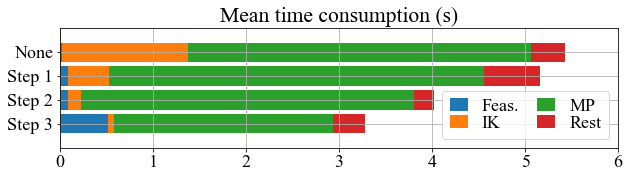

In [315]:
_, ax = plt.subplots(figsize=(10,2.2))
grouped_bar(times_dict, show_bar=False, invert_axis=True, options=COMP_LIST, stack=True)
plt.xlim(0,6)
plt.legend(COMP_LIST, ncol=len(COMP_LIST)/2, handlelength=1, labelspacing=0, columnspacing=1, loc="lower right")
ax.invert_yaxis()
plt.title("Mean time consumption (s)")

In [310]:
##
# @brief draw grouped bar
# @remark if value is list, mean and error bar are drawn
# @param data_dict dictionary of value dictionaries {group: case: value}
# @param groups group name list
# @param options sub-group option name list
# @param average_all do not separate group and average all in one graph
# @param autoscale auto fit y axis
def grouped_bar(data_dict, groups=None, options=None, scatter=False, average_all=False, autoscale=True, show_bar=True, fn=np.mean, 
                invert_axis=False, stack=False):
    if invert_axis:
        plot_fn=plt.barh
    else:
        plot_fn=plt.bar
    if groups is None:
        groups = sorted(data_dict.keys())
        
    if options is None:
        options = sorted(data_dict[groups[0]].keys())

    groups = [group for group in groups if group in data_dict]
    if stack:
        X_big = np.arange(len(groups)) +1
    else:
        X_big = np.arange(len(groups)) * (len(options) + 1) +1
    X_small = np.arange(len(options))

    dat_max = 0
    dat_min = 1e10
    dat_vec_accum = 0
    for xsmall in X_small:
        zorder = xsmall
        dat_vec = [data_dict[group][options[xsmall]] for group in groups]
        if len(dat_vec) == 0:
            continue
        if scatter:
            Xs = np.concatenate([[x]*len(tvec)for x, tvec in zip(X_big+xsmall, dat_vec)])
            dat_vec = np.concatenate(dat_vec)
            plt.plot(Xs, dat_vec, '.')
            dat_max = max(dat_max, np.max(dat_vec))
            dat_min = min(dat_min, np.min(dat_vec))
        else:
            if stack:
                xsmall=0
            if average_all:
                if isinstance(dat_vec[0], Iterable):
                    dat_vec = np.concatenate(dat_vec)
                if show_bar:
                    if show_bar is True:
                        std_vec = np.std(dat_vec)
                        std_vec = [[std_vec], [std_vec]]
                    else:
                        std_vec = (np.percentile(dat_vec, [50-show_bar*50, 50+show_bar*50])*[-1,1] + np.multiply(fn(dat_vec),[1,-1]))[:, np.newaxis]
                    dat_vec = fn(dat_vec)
                    
                    if stack:
                        dat_vec_accum = np.add(dat_vec_accum, dat_vec)
                        dat_vec = dat_vec_accum
                    if invert_axis:
                        plot_fn(xsmall, dat_vec, xerr=std_vec, capsize=3, zorder=-zorder)
                    else:
                        plot_fn(xsmall, dat_vec, yerr=std_vec, capsize=3, zorder=-zorder)
                else:
                    std_vec = None
                    dat_vec = fn(dat_vec)
                    
                    if stack:
                        dat_vec_accum = np.add(dat_vec_accum, dat_vec)
                        dat_vec = dat_vec_accum
                        
                    plot_fn(xsmall, dat_vec, capsize=3, zorder=-zorder)
            else:
                if isinstance(dat_vec[0], Iterable):
                    if show_bar is True:
                        std_vec = map(np.std, dat_vec)
                        std_vec = [std_vec, std_vec]
                    else:
                        std_vec = map(lambda __x: np.percentile(__x, [50-show_bar*50, 50+show_bar*50])*[-1,1] + np.multiply(fn(__x),[1, -1]), dat_vec)
                        std_vec = np.transpose(std_vec)
                    dat_vec = map(fn, dat_vec)
                else:
                    std_vec = None
                    
                if stack:
                    dat_vec_accum = np.add(dat_vec_accum, dat_vec)
                    dat_vec = dat_vec_accum
                    print(dat_vec_accum)
                if show_bar and std_vec is not None:
                    if invert_axis:
                        plot_fn(X_big+xsmall, dat_vec, xerr=std_vec, capsize=3, zorder=-zorder)
                    else:
                        plot_fn(X_big+xsmall, dat_vec, yerr=std_vec, capsize=3, zorder=-zorder)
                else:
                    plot_fn(X_big+xsmall, dat_vec, capsize=3, zorder=-zorder)
            dat_max = max(dat_max, np.max(np.add(dat_vec, std_vec[1]) 
                                           if std_vec is not None 
                                           else dat_vec))
            dat_min = min(dat_min, np.min(np.subtract(dat_vec, std_vec[0]) 
                                           if std_vec is not None 
                                           else dat_vec))
    margin = (dat_max - dat_min)/3+abs(dat_min)/100
    if autoscale:
        if average_all:
            if invert_axis:
                plt.axis([dat_min-margin, dat_max+margin, -0.7,np.max(X_small)+0.7])
            else:
                plt.axis([-0.7,np.max(X_small)+0.7, dat_min-margin, dat_max+margin])
        else:
            if stack:
                label_axis = [0,np.max(X_big)+1]
            else:
                label_axis = [0,np.max(X_big)+np.max(X_small)+1]
            if invert_axis:
                plt.axis([dat_min-margin, dat_max+margin]+label_axis)
            else:
                plt.axis(label_axis + [dat_min-margin, dat_max+margin])
    plt.grid()
    if average_all:
        if invert_axis:
            plt.yticks(X_small, np.array(options))
        else:
            plt.xticks(X_small, np.array(options))
    else:
        if stack:
            mean_X_small = 0
        else:
            mean_X_small = np.mean(X_small)
        if invert_axis:
            plt.yticks(X_big + mean_X_small, np.array(groups))
        else:
            plt.xticks(X_big + mean_X_small, np.array(groups))
        plt.legend(options)
    return groups, options

In [20]:
time_means_all = []
for xlabel in XLABEL_LIST:
    time_means_all.append(np.mean(np.concatenate([times_full[onum][xlabel] for onum in [3,5,7]])))
    print("{:8}:{:8}".format(xlabel, time_means_all[-1]))

N       :5.99138648877
S1      :5.63735274431
S2      :4.32841789851
S3      :3.53417345444


In [21]:
print("".join(["{:8}".format(x) for x in XLABEL_LIST]))
print("".join(["{:8}".format(x) 
               for x in np.round((1-np.divide(time_means_all, time_means_all[0]))*100, 2)]))
print("".join(["{:8}".format(x) 
               for x in np.round(time_means_all, 2)]))

N       S1      S2      S3      
     0.0    5.91   27.76   41.01
    5.99    5.64    4.33    3.53


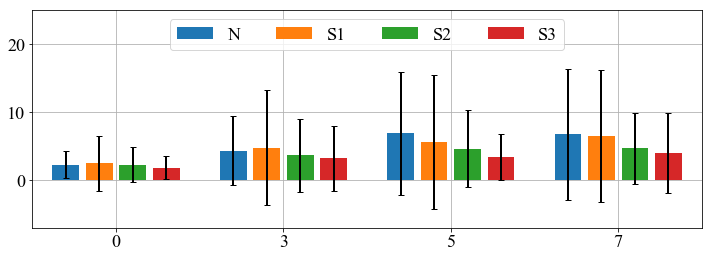

In [22]:
plt.figure(figsize=(12, 4))
_ = grouped_bar(times_full, average_all=False, options=XLABEL_LIST, show_bar=True)
plt.ylim(-7, 25)
plt.legend(XLABEL_LIST, ncol=len(XLABEL_LIST), loc="upper center")

In [23]:
for k in sorted(times_full.keys()):
    print(
        "{:8}:{:8}".format(k,
                           round((1 - np.mean(times_full[k]['Step 3']) / np.mean(times_full[k]['None'])) * 100, 2)))

KeyError: 'Step 3'

In [ ]:
print("="*80)
success_vecs = [np.concatenate(map(lambda x: x[cname], succ_dict.values())) for cname in CNAME_LIST]
success_means = map(np.mean, success_vecs)
max_val = np.max(success_means)
max_idc = np.where(success_means==max_val)[0]
print("MP_TIMES: ", "  ".join(map(lambda x:"{:5}".format(x), CNAME_LIST)))
print("success: ", "  ".join(map(lambda x:"{:5.03}".format(x), success_means)))
print("best: {} ({:5.3})".format(np.array(CNAME_LIST)[max_idc], max_val))
print("-"*80)
time_vecs = [np.concatenate(map(lambda x: x[cname], time_dict.values())) for cname in CNAME_LIST]
time_means = np.array(map(np.mean, time_vecs))
min_val = np.min(time_means[max_idc])
min_idc = np.where(time_means[max_idc]==min_val)[0]
print("MP_TIMES: ", "  ".join(map(lambda x:"{:5}".format(x), CNAME_LIST)))
print("times  : ", "  ".join(map(lambda x:"{:5.03}".format(x), time_means)))
print("best: {} ({:5.3})".format(np.array(CNAME_LIST)[max_idc][min_idc], min_val))
print("="*80)

In [ ]:
(1 - 5.16 / 5.43 )*100

#### stowing-deep-result-btf-ik08-to2.0-bak-1005-step03replaced-with-noMPprefilter-res
```
================================================================================
('MP_TIMES: ', 'None   Tool   ToolReach  Full ')
('success: ', '0.974  0.971  0.969  0.974')
best: ['None' 'Full'] (0.974)
--------------------------------------------------------------------------------
('MP_TIMES: ', 'None   Tool   ToolReach  Full ')
('times  : ', ' 6.45    5.1   4.61   3.87')
best: ['Full'] ( 3.87)
================================================================================
```
#### stowing-deep-result-btf-ik08-to2.0-all-noMPprefilter
```
================================================================================
('MP_TIMES: ', 'None   Tool   ToolReach  Full ')
('success: ', '0.957  0.977  0.977  0.969')
best: ['Tool' 'ToolReach'] (0.977)
--------------------------------------------------------------------------------
('MP_TIMES: ', 'None   Tool   ToolReach  Full ')
('times  : ', ' 4.72    4.0   4.11   3.76')
best: ['Tool'] (  4.0)
================================================================================
```